# Few-Shot Experiments on Extraction Task

This notebook, walks through how to run benchmarks on a tool calling model using the Extraction Task dataset.

## Setup

First, let's setup our imports.

In [70]:
import sys
sys.path.append("../../../../langchain_benchmarks")
from tool_usage.tasks.extraction_query import *
from datetime import datetime
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langsmith.evaluation import evaluate
from langsmith.evaluation.evaluator import (
    EvaluationResult,
    EvaluationResults,
)
from langsmith.schemas import Example, Run
from typing import Optional
from langsmith.client import Client
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage
from langchain_community.vectorstores import FAISS
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts.few_shot import FewShotChatMessagePromptTemplate
from collections import Counter
from langchain.chat_models import init_chat_model

# Define our LangSmith client so we have access to it throughout the rest of the notebook
client = Client()

## Set up Evaluation

## Helper functions

First, let us set up a few helper functions. The `calculate_recall` helper function is used because we are testing the ability of the model to correctly query all of the expected queries, and we are not punishing it for querying extra information. The `is_iso_format` funciton is used since some of the fields we are testing for accuracy are in `datetime` format. We use LLM-as-a-judge for determining whether the actual search query provided by the model is similar in meaning to the search query we were expecting.

In [76]:
def calculate_recall(A, B):
    # Count the occurrences of each element in A and B
    count_A = Counter(A)
    count_B = Counter(B)
    
    # Calculate the number of true positives
    true_positives = sum(min(count_A[elem], count_B.get(elem, 0)) for elem in count_A)
    
    # Calculate recall
    recall = true_positives / sum(count_A.values()) if count_A else 0
    
    return recall

def is_iso_format(date_str):
    if not isinstance(date_str,str):
        return False
    try:
        # Try to parse the string with datetime.fromisoformat
        datetime.fromisoformat(date_str)
        return True
    except ValueError:
        return False

llm_judge = ChatOpenAI(model="gpt-4o")

judge_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an llm tasked with determining if the subject extracted by another LLM is an accurate "
            "representation of the correct answer. You are to check for general semantic similarity since the words might not "
            "match up perfectly but the meaning might still be the same. Return YES if the answers match, and NO otherwise. "
            "Never return anything other than YES or NO.",
        ),
        (
            "human",
            "Is this query: {run_query} somewhat similar to this reference query: {reference_query}",
        ),
    ]
)

judge_chain = judge_prompt | llm_judge | StrOutputParser()

# Tools imported from extract_query file
tools = [DocQuery, TweetQuery, BlogQuery]

### Define Evaluator Function

Now we are ready to define our evaluator function. Our evaluator function will check that all of the expected tool calls are reproduced by the model with the correct arguments as well. If all the expected tool calls are in the final response with the correct arguments, we assign an overall score of 1. We also give partial credit for calling the correct tools, getting the correct deterministic arguments, and getting the correct undeterministic arguments as well.

In [77]:
def compare_outputs(run_outputs: dict, example_outputs: dict) -> EvaluationResults:
    if len(run_outputs['response'].tool_calls) == 0:
        correct_tool_score, determinstic_score, underministic_score = 0,0,0
    else:
        # Chose the correct tool
        reference_tools = [tool["name"] for tool in example_outputs["reference"]]
        outputted_tools = [tool["name"] for tool in run_outputs["response"].tool_calls]
        correct_tool_score = calculate_recall(reference_tools,outputted_tools)

        # Has the correct determenistic args
        determinstic_score = 0
        # Has the correct undetermenistic args
        underministic_score = 0

        if correct_tool_score == 1:
            determinstic_score, underministic_score = 1, 1
            for tool in example_outputs["reference"]:
                corresponding_response_tool = [
                        t
                        for t in run_outputs["response"].tool_calls
                        if t["name"] == tool["name"]
                    ][0]["args"]
                for arg in tool["args"]:
                    # Check that outputted search query matches the meaning of expected search query
                    if arg in ["query", "subject"]:
                        ans = judge_chain.invoke(
                            {
                                "run_query": corresponding_response_tool[arg],
                                "reference_query": tool["args"][arg],
                            }
                        )
                        underministic_score = 1 if ans == "YES" else 0
                    else:
                        # Check that tool call arguments are correct (being careful with datetime objects)
                        if (
                            tool["args"][arg] and arg not in corresponding_response_tool
                        ) or (
                            tool["args"][arg]
                            and not (tool["args"][arg] == corresponding_response_tool[arg])
                            and not (is_iso_format(tool["args"][arg]) 
                                and is_iso_format(corresponding_response_tool[arg]) 
                                and datetime.fromisoformat(
                                    (corresponding_response_tool[arg])
                                ).replace(tzinfo=None)
                                == datetime.fromisoformat(tool["args"][arg])
                            )
                        ):
                            determinstic_score = 0
    # Overall correctness
    overall_score = int(
        correct_tool_score == 1
        and bool(determinstic_score)
        and bool(underministic_score)
    )
    results = [
        EvaluationResult(
            key="Correct tool",
            score=correct_tool_score,
        ),
        EvaluationResult(
            key="Correct determenistic args",
            score=determinstic_score,
        ),
        EvaluationResult(
            key="Correct undermenistic args",
            score=underministic_score,
        ),
        EvaluationResult(
            key="Overall correctness",
            score=overall_score,
        ),
    ]

    return {"results": results}


def evaluate_run(run: Run, example: Optional[Example] = None) -> EvaluationResults:
    return compare_outputs(run.outputs, example.outputs)

## Few-Shot preparation

We are now ready for preparing for running our evaluation scipt across different few-shot prompting strategies. In this next code cell, we pull the uncleaned few-shot examples from LangSmith and then create a dataset for semantic search, as well as an overall few-shot list of messages and overall string - both of which we will insert into the prompt for few-shot testing.

In [78]:
uncleaned_examples = [
    e
    for e in client.list_examples(
        dataset_name="Extraction Task Few Shot"
    )
]
few_shot_messages, few_shot_str = [], ""
few_shot_messages_by_index = {}
examples_for_semantic_search = []

for j,example in enumerate(uncleaned_examples):
    few_shot_messages_for_example = []
    few_shot_messages_for_example.append(HumanMessage(name="example_human",content=example.inputs['question'][0]['content']))
    few_shot_messages_for_example.append(AIMessage(name="example_assistant", content="", tool_calls=[{"name": tc["name"], "args": tc["args"], "type": "tool_call", "id": f"{10*j+i}"} for i, tc in enumerate(example.outputs["reference"])]))
    few_shot_str += f"<|im_start|>user\n{example.inputs['question'][0]['content']}\n<|im_end|>"
    few_shot_str += "\n<|im_start|>assistant\n"
    for i, tool_call in enumerate(example.outputs["reference"]):
        few_shot_messages_for_example.append(ToolMessage("You have correctly called this tool", name=tool_call["name"], tool_call_id=f"{10*j+i}"))
        few_shot_str += f"Tool Call: Name: {tool_call['name']} Args: {{{', '.join(f'{k}: {v}' for k,v in tool_call['args'].items())}}}"
        few_shot_str += "\n"
    few_shot_str += "<|im_end|>"

    few_shot_messages += few_shot_messages_for_example
    few_shot_messages_by_index[j] = few_shot_messages_for_example
    examples_for_semantic_search.append({"question":example.inputs['question'][0]['content'],"messages":few_shot_messages_for_example})

## Prediction Function

Next, we can write our prediction function, which will vary depending on the few-shot method provided. The function is very similar for all of the methods except for the semantic search method. In the semantic search method, we need to add a little extra logic to pull the correct examples before inserting them into the prompt.

In [79]:
# 3 static indices to compare against using semantic search to select 3 few-shot examples
static_indices = [0,2,5]

# Default prompt format we will use for all examples
prompt = ChatPromptTemplate.from_messages(
                    [
                        ("system", "{instructions}"),
                        MessagesPlaceholder("few_shot_message_list"),
                        ("human", "{input}"),
                    ]
)

def predict_for_model(model,instructions,few_shot_method):
    few_shot_message_list = []
    chain = prompt | model.bind_tools(tools,tool_choice="any").with_retry(stop_after_attempt=5)
    if few_shot_method == "few-shot-string":
        instructions += f"\n Here are some examples: \n {few_shot_str}"
    elif few_shot_method == "few-shot-messages":
        few_shot_message_list = few_shot_messages
    elif few_shot_method == "few-shot-static-messages":
        few_shot_message_list = [message for index in static_indices for message in few_shot_messages_by_index[index]]
    elif few_shot_method == "few-shot-dynamic-messages":
        def predict(example: dict):
            example_selector = SemanticSimilarityExampleSelector.from_examples(
                examples_for_semantic_search,
                OpenAIEmbeddings(),
                FAISS,
                k=3,
                input_keys=["question"],
                example_keys=["messages"],
            )

            few_shot_prompt = FewShotChatMessagePromptTemplate(
                input_variables=[],
                example_selector=example_selector,
                example_prompt=MessagesPlaceholder("messages"),
            )
            return {"response": chain.invoke({"input":example["question"],"instructions":instructions,"few_shot_message_list":few_shot_prompt.invoke({"question":example["question"][0]['content']}).messages})}
        return predict
    
    def predict(example: dict):
        return {"response": chain.invoke({"input":example["question"],"instructions":instructions,"few_shot_message_list":few_shot_message_list})}
    
    
    return predict

## Running the Experiment

Now that we have defined our evaluation function, we can actually run our evaluation! The code below loops through different models and then calls our evaluator function on all of them. 

In [ ]:
models = [
            ("claude-3-haiku-20240307","anthropic",),
            ("claude-3-sonnet-20240229","anthropic",),
            ("claude-3-opus-20240229","anthropic",),
            ("claude-3-5-sonnet-20240620","anthropic",),
            ("gpt-3.5-turbo-0125","openai"),
            ("gpt-4o","openai"),
            ("gpt-4o-mini","openai"),
            ("llama3-groq-70b-8192-tool-use-preview","groq"),
            ("llama3-groq-8b-8192-tool-use-preview","groq")
        ]
# These are all the currently supported methods
few_shot_methods = ["no-few-shot","few-shot-string","few-shot-messages","few-shot-static-messages","few-shot-dynamic-messages"]


for model_name, model_provider in models:
    model = init_chat_model(model_name,model_provider=model_provider)
    for few_shot_method in few_shot_methods:
        evaluate(
            predict_for_model(model,EXTRACTION_TASK.instructions,few_shot_method),
            data=EXTRACTION_TASK.name,
            evaluators=[evaluate_run],
            experiment_prefix=f"test-{model_name}-{few_shot_method}",
        )

## Visualize Results

In [83]:
from datetime import datetime

today = datetime.today().date().isoformat()
projects = [p for p in client.list_projects(reference_dataset_name="Extraction Task") if p.start_time.date().isoformat() == today]

In [85]:
models = set([p.name.split("-TEST")[0] for p in projects])
few_shot_type = set([p.name.split("TEST-")[1] for p in projects])
few_shot_type = set([t[t.index("-")+1:t.rfind("-")] for t in few_shot_type])

In [86]:
from tqdm import tqdm
results_dic = {}
for model in tqdm(models,total=len(list(models))):
    model_results = []
    for few_shot in few_shot_type:
        experiments = [p for p in projects if model in p.name and few_shot in p.name]
        model_results.append(100*client.get_run_stats(project_ids=[experiment.id for experiment in experiments])['feedback_stats']['overall correctness']['avg'])
    results_dic[model] = model_results

100%|██████████| 7/7 [00:29<00:00,  4.26s/it]


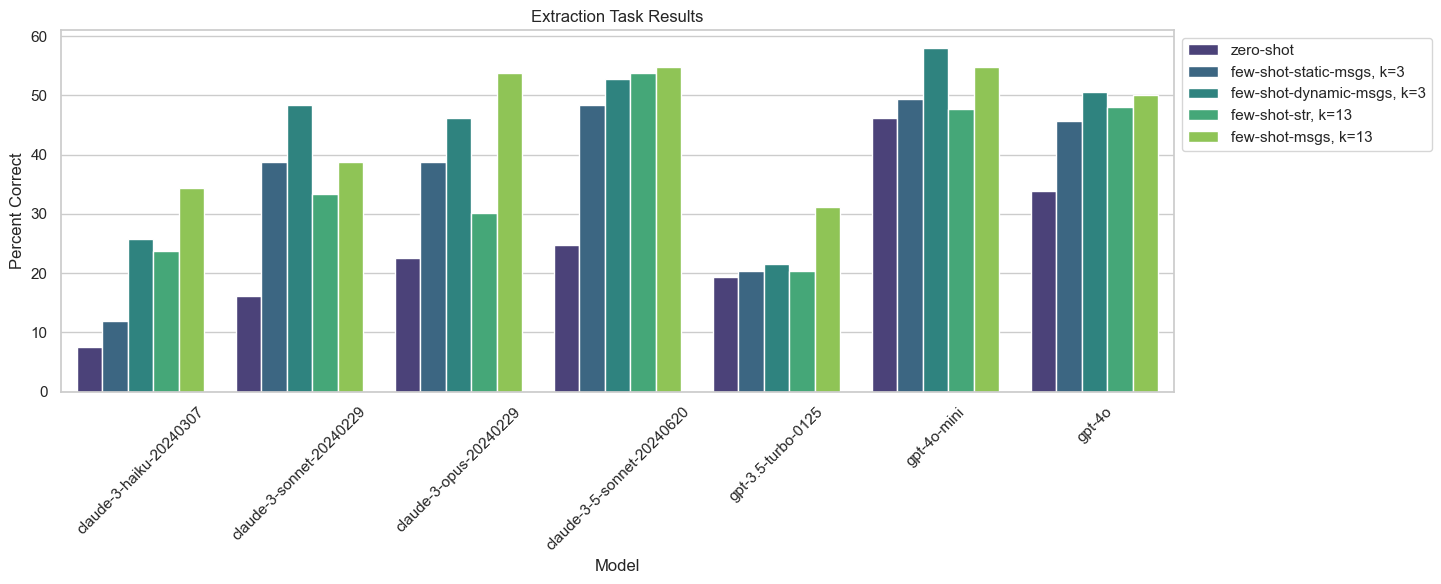

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


results = np.array([results_dic[model] for model in models])

# Create a DataFrame for Seaborn plotting
df = pd.DataFrame(results.T, columns=list(models))
df['Few Shot Type'] = list(few_shot_type)
df.iloc[[0, 2]] = df.iloc[[2, 0]].to_numpy()
df.iloc[[1, 2, 3, 4]] = df.iloc[[4, 3, 2, 1]].to_numpy()
df = df[df.columns[[6, 2, 5, 1, 0, 4, 3, 7]]]
# Melt the DataFrame to long format for Seaborn's barplot
df_melted = df.melt(id_vars='Few Shot Type', var_name='Model', value_name='Percent Correct')

# Set up Seaborn parameters
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Plot using Seaborn
sns.barplot(x='Model', y='Percent Correct', hue='Few Shot Type', data=df_melted, palette='viridis')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Percent Correct')
plt.title('Extraction Task Results')
plt.xticks(rotation=45)
plt.tight_layout()

legend_labels = {
    "no-few-shot": "zero-shot",
    "few-shot-messages": "few-shot-msgs, k=13",
    "few-shot-string": "few-shot-str, k=13",
    "few-shot-dynamic-messages": "few-shot-dynamic-msgs, k=3",
    "few-shot-static-messages": "few-shot-static-msgs, k=3"
}
# Get the current handles and labels from the plot
handles, labels = plt.gca().get_legend_handles_labels()
labels = [legend_labels.get(label, label) for label in labels]

# Update the legend with the new labels
plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Comparing Semantic Search

We can also calculate the average correctness when using semantic search to generate the few-shot examples v.s. when we just pick a static three examples.

In [93]:
dynamic_experiments = [p for p in projects if "dynamic" in p.name]
static_experiments = [p for p in projects if "static" in p.name]

dynamic_overall = 100*client.get_run_stats(project_ids=[experiment.id for experiment in dynamic_experiments])['feedback_stats']['overall correctness']['avg']
static_overall = 100*client.get_run_stats(project_ids=[experiment.id for experiment in static_experiments])['feedback_stats']['overall correctness']['avg']

print(f"Overall Accuracy with dynamic few shot: {dynamic_overall}, and static: {static_overall}")

Overall Accuracy with dynamic few shot: 42.242703533026116, and static: 35.63748079877112
